# Imports

In [1]:
import os; os.chdir('..')
%load_ext autoreload
%autoreload 2

In [3]:
import perustats
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import altair as alt
import matplotlib.pyplot as plt
from pathlib import Path
alt.renderers.enable('notebook')
%matplotlib inline

In [3]:
PATH_OUT = Path('data/processed/criminality')

# Getting ratio

In [11]:
df_pop = pd.read_csv(PATH_OUT/'population_inei.csv')
df_pop = df_pop.set_index(['ambito', 'indicador'])['2015'].fillna(0).unstack().reset_index()
df_pop.columns.name = None
df_pop['poblacion_total'] = df_pop.poblacion_total_rural + df_pop.poblacion_total_urbana

df = pd.read_csv(PATH_OUT/'tipo-ubicacion.csv')
df.loc[df.departamento == 'Lima Provincias', 'departamento'] = 'Lima'
df = (df.groupby(['year', 'departamento', 'variable']).sum().reset_index().
          merge(df_pop, 'left', left_on='departamento', right_on='ambito').
          assign(ratio = lambda x: x.value / x.poblacion_total).
          assign(poblacion = lambda x: x.poblacion_total).
          set_index(['year', 'departamento', 'variable'])[['value', 'ratio', 'poblacion']])

df.head()

value  \
year departamento variable                                                
2015 Amazonas     delitos-contra-el-estado-y-la-defensa-nacional      3   
                  delitos-contra-el-honor                            10   
                  delitos-contra-el-orden-economico                   1   
                  delitos-contra-el-orden-financiero-y-monetario     10   
                  delitos-contra-el-patrimonio                     1426   

                                                                     ratio  \
year departamento variable                                                   
2015 Amazonas     delitos-contra-el-estado-y-la-defensa-nacional  0.000007   
                  delitos-contra-el-honor                         0.000024   
                  delitos-contra-el-orden-economico               0.000002   
                  delitos-contra-el-orden-financiero-y-monetario  0.000024   
                  delitos-contra-el-patrimonio                    0.003374   

                                                                  poblacion  
year departamento variable                                                   
2015 Amazonas     delitos-contra-el-estado-y-la-defensa-nacional   422629.0  
                  delitos-contra-el-honor                          422629.0  
                  delitos-contra-el-orden-economico                422629.0  
                  delitos-contra-el-orden-financiero-y-monetario   422629.0  
                  delitos-contra-el-patrimonio                     422629.0

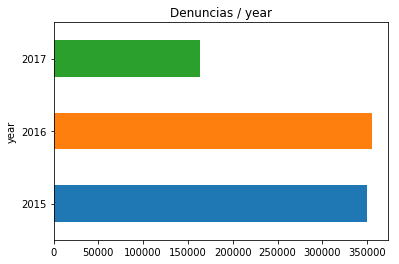

In [12]:
df.groupby('year')['value'].sum().plot.barh(title='Denuncias / year');

As 2017 seems to have missing data, I will mainly use 2016 data.

In [115]:
df_2016 = df.loc[2016].reset_index()

# Altair Plots

In [116]:
df_2016.head(2)

,departamento,variable,value,ratio,poblacion
0,Amazonas,delitos-contra-el-estado-y-la-defensa-nacional,1,0.000002,422629.0
1,Amazonas,delitos-contra-el-honor,8,0.000019,422629.0


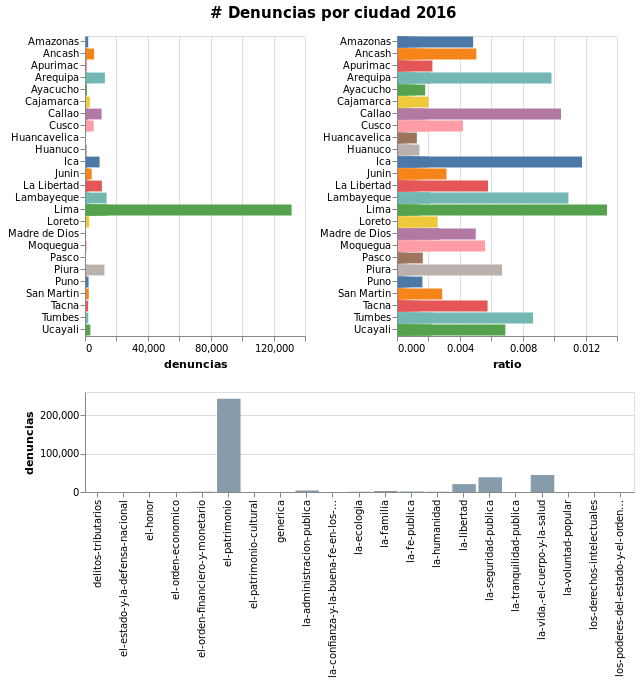

In [236]:
select = alt.selection_single(on='mouseover', fields=['departamento'])
tooltip = alt.selection_single(on='mouseover', fields=['variable'], empty='none')

base = alt.Chart(
    df_2016.assign(variable = lambda x: x.variable.str.replace('delitos-contra-', ''))
).mark_bar().encode(
    y=alt.Y('departamento', title=None),
    color=alt.condition(select, 'departamento', alt.value('lightgray'), legend=None)
)

p1 = base.encode(
    x=alt.X('value', title='denuncias'),
).properties(
    selection=select,
    width = 220, height=300
)

p2 = base.encode(
    x='ratio',
).properties(
    selection=select,
    width = 220, height=300
)

p3 = base.encode(
    x=alt.X('variable', title=None),
    y=alt.Y('sum(value)', title='denuncias'),
    color=alt.condition(tooltip, alt.ColorValue('#4a708b'), alt.value('#879cab'))
).transform_filter(select).properties(
    width=549, height=100
)

p3_text = p3.mark_text(align='left', dx=5, dy=-5, fontSize=11).encode(
    text=alt.condition(tooltip, 'variable', alt.value(' ')),
    color=alt.ColorValue('black')
).properties(selection=tooltip)

chart = alt.vconcat((p1 | p2), (p3 + p3_text), title='                         # Denuncias por ciudad 2016')
chart = chart.configure(title=alt.VgTitleConfig(fontSize=15, offset=15))
chart.save('reports/charts/delitos-denuncias2016.html')
chart

# Plots

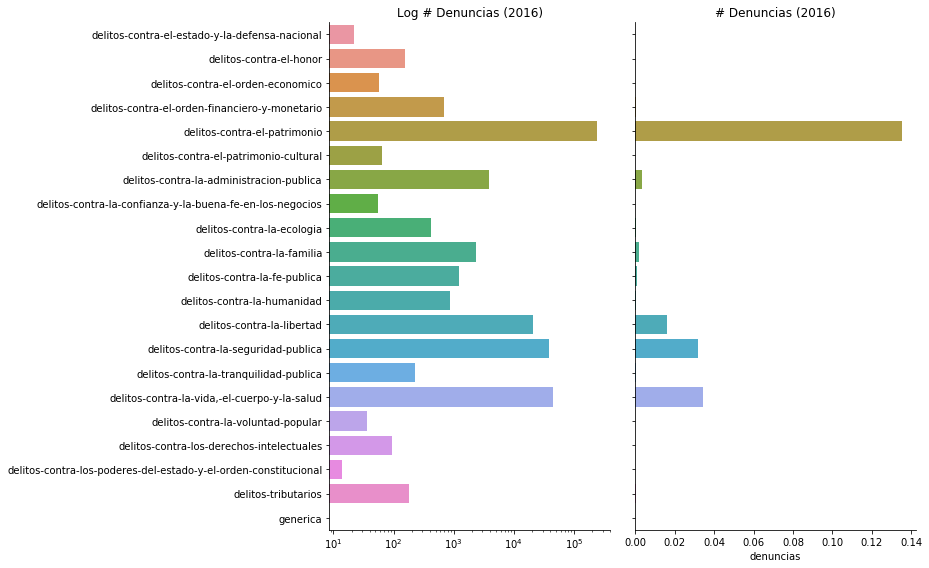

In [196]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(13,8))

df_denuncias = (df.loc[2016].
                   groupby('variable').
                   agg({'value': 'sum', 'ratio': 'sum', 'poblacion': 'mean'}).
                   reset_index().
                   assign(value_perc=lambda x: x.value / x.value.sum()))

sns.barplot(df_denuncias.value, df_denuncias.variable, ax=axes[0])
axes[0].set_title('Log # Denuncias (2016)')
axes[0].set_xlabel('')
axes[0].set_xscale('log')

sns.barplot(df_denuncias.ratio, df_denuncias.variable, ax=axes[1])
axes[1].set_title('# Denuncias (2016)')
axes[1].set_xlabel('denuncias')

for ax in axes: ax.set_ylabel('')
plt.tight_layout()
sns.despine()

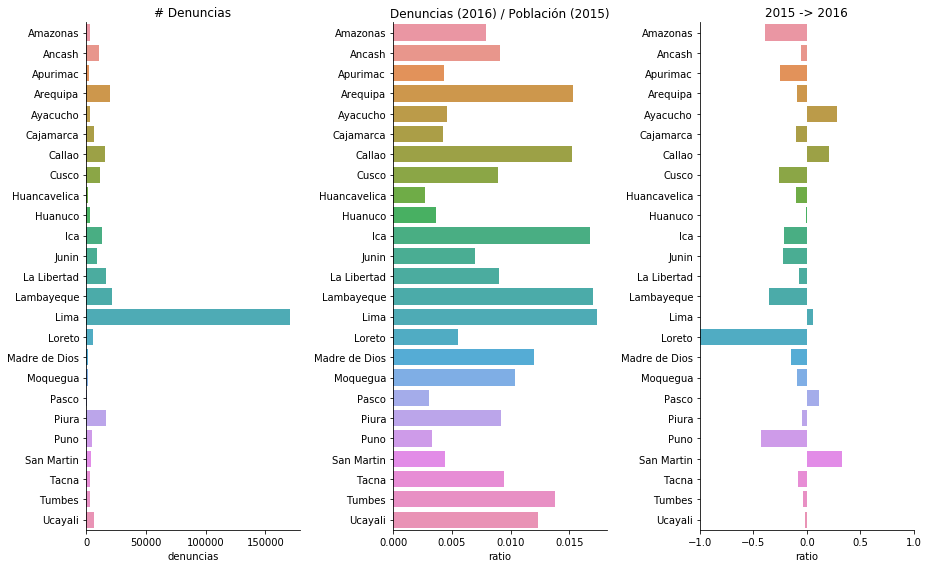

In [236]:
fig, axes = plt.subplots(1, 3, figsize=(13,8))

df_departments = (df.loc[2016].
                     groupby('departamento').
                     agg({'value': 'sum', 'ratio': 'sum', 'poblacion': 'mean'}).
                     reset_index())

sns.barplot(df_departments.value, df_departments.departamento, ax=axes[0])
axes[0].set_title('# Denuncias')
axes[0].set_xlabel('denuncias')

sns.barplot(df_departments.ratio, df_departments.departamento, ax=axes[1])
axes[1].set_title('Denuncias (2016) / Población (2015)')
axes[1].set_xlabel('ratio')

t = df.groupby(['year', 'departamento'])['value'].sum()
t = ((t[2015] - t[2016]) / t[2015]).reset_index()
sns.barplot('value', 'departamento', data=t, ax=axes[2])
axes[2].set_title('2015 -> 2016')
axes[2].set_xlabel('ratio')
axes[2].set_xlim(-1,1)

for ax in axes: ax.set_ylabel('')
plt.tight_layout()
sns.despine()

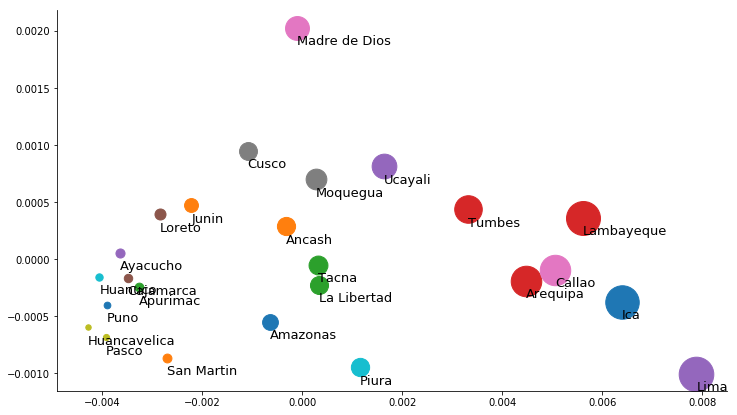

In [192]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(2)
t = df.loc[2016, 'ratio'].unstack(0).T
dep_ratio = df_departments.set_index('departamento')['ratio']

plt.figure(figsize=(12,7))
t_pca = pca.fit_transform(t)
for n,(x,y) in zip(t.index, t_pca):
    size = dep_ratio[n]*2000
    plt.plot(x, y, 'o', markersize=size)
    plt.text(x, y-15e-5, n, fontsize=13)
    
sns.despine()

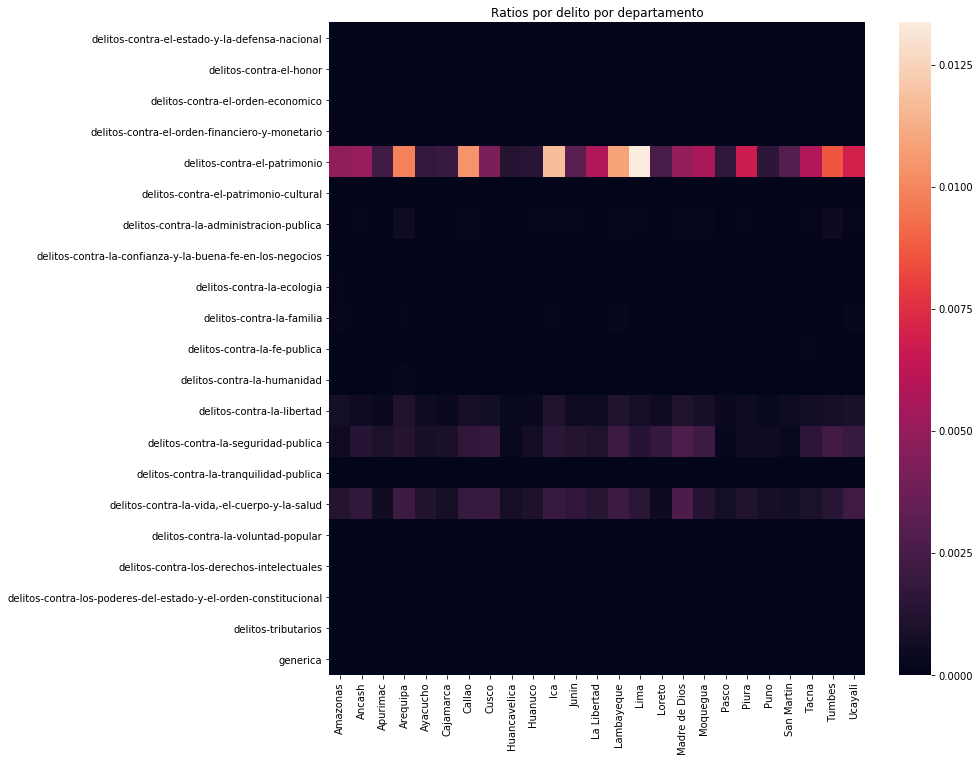

In [193]:
plt.figure(figsize=(12,12))
sns.heatmap(t.T)
plt.xlabel(''); plt.ylabel('')
plt.title('Ratios por delito por departamento');

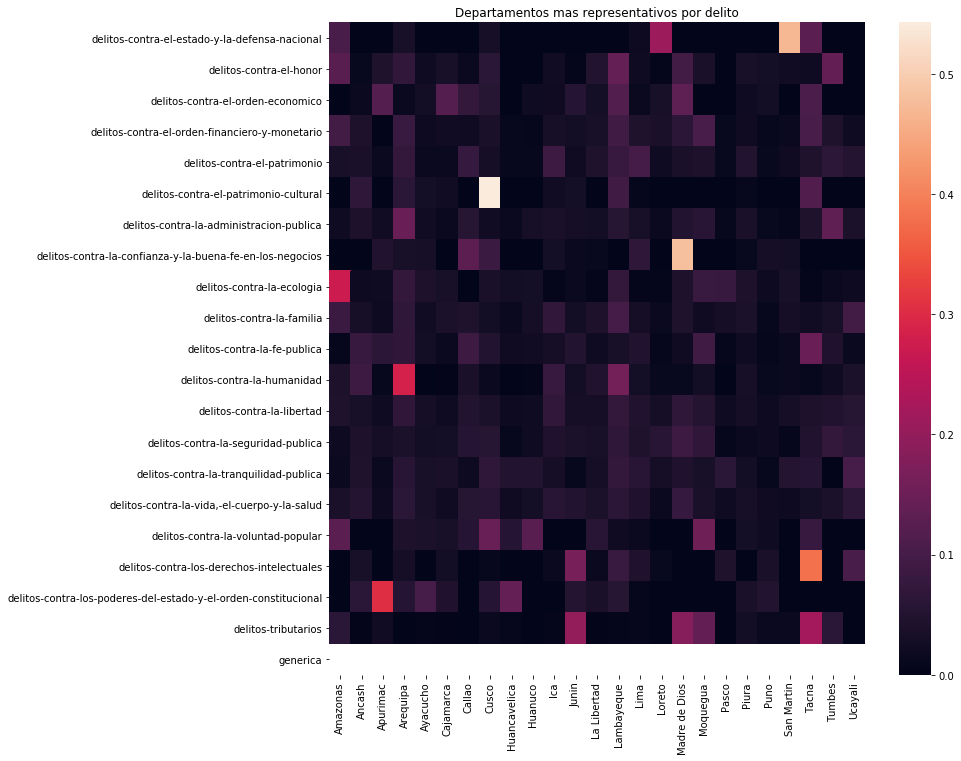

In [194]:
plt.figure(figsize=(12,12))
t = df.loc[2016, 'ratio'].unstack(0).T
sns.heatmap(t.apply(lambda x: x/x.sum(), axis=0).T)
plt.xlabel(''); plt.ylabel('')
plt.title('Departamentos mas representativos por delito');

# Maps

In [197]:
geos = (gpd.read_file('data/raw/peru_departamental_simple.geojson').
            assign(NOMBDEP=lambda x: x.NOMBDEP.str.title().str.replace('De', 'de')).
            merge(df_departments, 'left', left_on='NOMBDEP', right_on='departamento').
            set_index('NOMBDEP').
            loc[:, ['geometry', 'value', 'ratio', 'poblacion']])
geos.head(2)

,geometry,value,ratio,poblacion
NOMBDEP,,,,
Amazonas,POLYGON ((-77.75893361195118 -6.96450785011829...,3340,0.007903,422629.0
Ancash,POLYGON ((-77.31748636153681 -8.53015235157666...,10446,0.009094,1148634.0


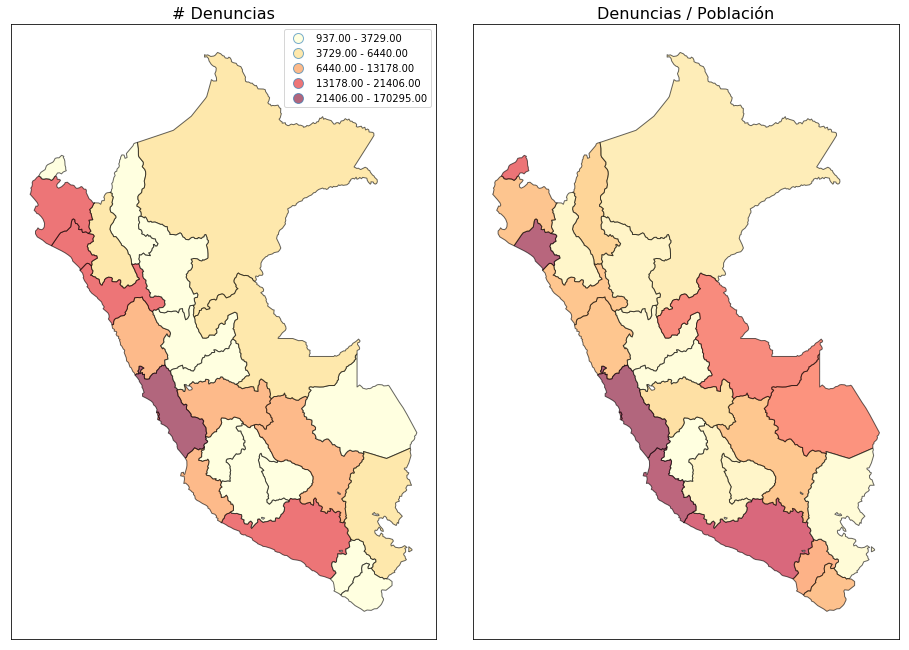

In [198]:
fig, axs = plt.subplots(1, 2, figsize=(13,9))

titles = ['# Denuncias', 'Denuncias / Población']
geos.plot(column='value', cmap='YlOrRd', scheme='Fisher_Jenks',
          legend=True, alpha=.6, edgecolor='black', ax=axs[0])
geos.plot(column='ratio', cmap='YlOrRd',# scheme='equal_interval',
          legend=False, alpha=.6, edgecolor='black', ax=axs[1])

for ax,t in zip(axs,titles):
    ax.set_title(t, fontdict={'fontsize': 16}); ax.set_xticks([]);ax.set_yticks([]);ax.set_aspect('equal')
    
plt.tight_layout()

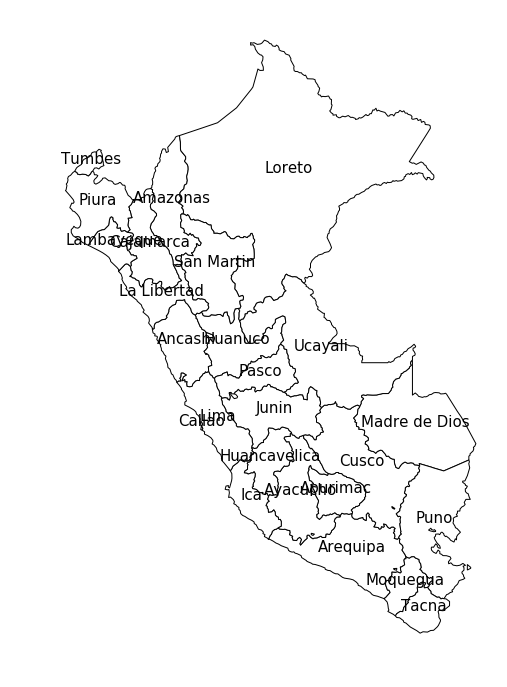

In [235]:
geos.plot(edgecolor='black', color='white', figsize=(12,12))
for n, [x,y] in geos.geometry.centroid.apply(lambda x: [x.xy[0][0], x.xy[1][0]]).items():
    plt.text(x, y, n, color='#000000', fontsize=15, horizontalalignment='center')
plt.axis('off');

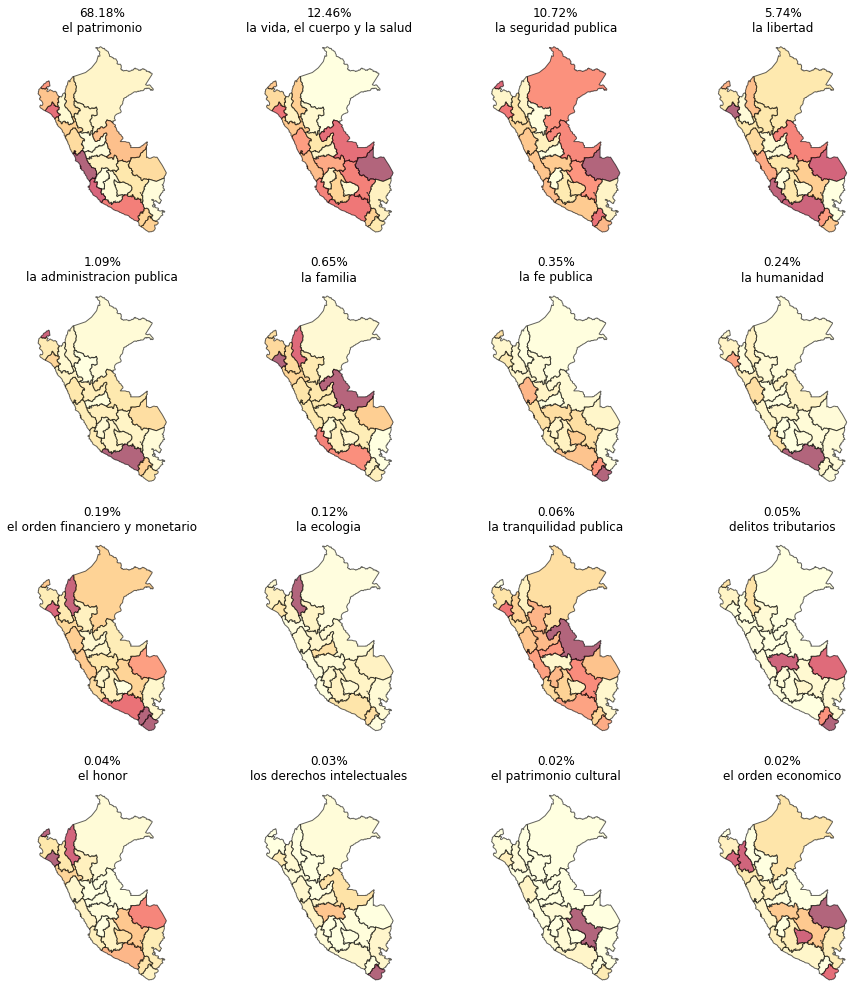

In [239]:
fig, axes = plt.subplots(4, 4, figsize=(13,14))

for ax,e in zip(axes.flatten(), df_denuncias.sort_values('value', ascending=False).variable):
    v = df_denuncias.query(f'variable == {e!r}').value_perc.iloc[0] * 100
    df_t = (df.loc[pd.IndexSlice[2016,:,e]].
               groupby('departamento').
               agg({'value': 'sum', 'ratio': 'sum', 'poblacion': 'mean'}).
               reset_index())
    df_t = (geos[['geometry']].
               merge(df_t, 'left', left_index=True, right_on='departamento'))#.set_index('departamento'))
    df_t.plot(column='ratio', cmap='YlOrRd',
              legend=False, alpha=.6, edgecolor='black', ax=ax)
    ax.set_title(f'{v:.2f}%\n{e.replace("delitos-contra-", "").replace("-"," ")}', fontdict={'fontsize': 12})
    ax.set_xticks([]);ax.set_yticks([]);ax.set_aspect('equal')
    ax.set_axis_off()
    
plt.tight_layout()